## **09-3) LSTM과 GRU 셀**

순환 신경망에서 빼놓을 수 없는 핵심 기술인 LSTM과 GRU 셀을 사용한 모델을 만든다.

#### **용어 정리**
- **LSTM 셀**: 타임스텝이 긴 데이터를 효과적으로 학습하기 위해 고안된 순환층. 입력 게이트, 삭제 게이트, 출력 게이트 역할을 하는 작은 셀이 포함되어 있다.
- **셀 상태**: LSTM 셀은 은닉 상태 외에 셀 상태를 출력하는데, 셀 상태는 다음 층으로 전달되지 않으며 현제 셀에서만 순환된다.
- **GRU 셀**: LSTM 셀의 간소화 버전으로 생각할 수 있지만 LSTM 셀에 못지않는 성능을 낸다.

<br><hr><br>

### **LSTM 신경망 훈련하기**

In [2]:
# IMDB 리뷰 데이터 로드하고 훈련 세트와 검정세트로 나누기
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

17473536/17464789 [==============================] - 0s 0us/step


In [4]:
# 각 샘플의 길이 100으로 맞추고 부족할 경우 패딩 추가
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [6]:
# LSTM 셀을 사용한 순환층 만들기
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [7]:
# 모델 구조 출력
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


LSTM 셀에는 작은 셀이 4개가 있으므로 SimpleRNN 클래스의 모델 파라미터 개수의 4배가 된다. 즉 모델 파라미터의 개수는 800개이다.

In [8]:
# 모델 컴파일 및 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(train_seq, train_target, epochs=100, batch_size=64,
                    validation_data=(val_seq, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 10s 9ms/step - loss: 0.6924 - accuracy: 0.5398 - val_loss: 0.6912 - val_accuracy: 0.5824
Epoch 2/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6894 - accuracy: 0.6061 - val_loss: 0.6870 - val_accuracy: 0.6290
Epoch 3/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6823 - accuracy: 0.6473 - val_loss: 0.6767 - val_accuracy: 0.6530
Epoch 4/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6571 - accuracy: 0.6772 - val_loss: 0.6224 - val_accuracy: 0.6906
Epoch 5/100
313/313 [==============================] - 3s 8ms/step - loss: 0.5795 - accuracy: 0.7279 - val_loss: 0.5616 - val_accuracy: 0.7390
Epoch 6/100
313/313 [==============================] - 3s 8ms/step - loss: 0.5433 - accuracy: 0.7462 - val_loss: 0.5330 - val_accuracy: 0.7572
Epoch 7/100
313/313 [==============================] - 3s 8ms/step - loss: 0.5185 - accuracy: 0.7627 - val_loss: 0.5127 - val_accuracy: 0.763

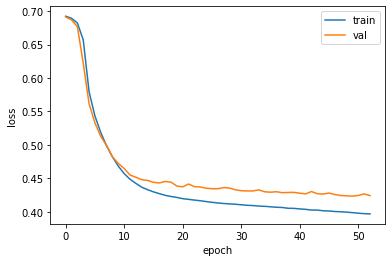

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

기본 순환층보다 LSTM이 과대적합을 억제하면서 훈련을 잘 수행한 것으로 볼 수 있다.

<br><hr><br>

### **순환층에 드롭아웃 적용하기**

**드롭아웃**은 은닉층에 있는 뉴런의 출력을 랜덤하게 꺼서 과대적합을 막는 기법이다.

SimpleRNN과 LSTM 클래스 모두 **`dropout`** 매개변수와 **`recurrent_dropout`** 매개변수를 가지고 있다.
- **dropout**) 셀의 입력에 드롭아웃 적용
- **recurrent_dropout**) 순환되는 은닉 상태에 드롭아웃 적용, 단, 이 매개변수를 사용하면 GPU를 사용하여 모델을 훈련하지 못한다.

In [10]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [11]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-dropout-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 5s 9ms/step - loss: 0.6926 - accuracy: 0.5373 - val_loss: 0.6921 - val_accuracy: 0.5862
Epoch 2/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6910 - accuracy: 0.6011 - val_loss: 0.6895 - val_accuracy: 0.6216
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6829 - accuracy: 0.6621 - val_loss: 0.6689 - val_accuracy: 0.6668
Epoch 4/100
313/313 [==============================] - 3s 10ms/step - loss: 0.6379 - accuracy: 0.6880 - val_loss: 0.6208 - val_accuracy: 0.6878
Epoch 5/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6080 - accuracy: 0.7038 - val_loss: 0.5994 - val_accuracy: 0.7042
Epoch 6/100
313/313 [==============================] - 3s 8ms/step - loss: 0.5863 - accuracy: 0.7199 - val_loss: 0.5752 - val_accuracy: 0.7306
Epoch 7/100
313/313 [==============================] - 3s 8ms/step - loss: 0.5667 - accuracy: 0.7358 - val_loss: 0.5632 - val_accuracy: 0.728

검증 손실이 약간 향상되었다.

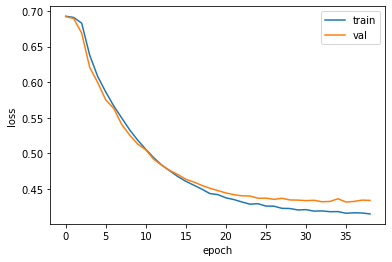

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

훈련 손실과 검증 손실 간 차이가 좁혀진 것을 확인할 수 있다.

<br><hr><br>

### **2개의 층을 연결하기**

순환층의 은닉 상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음 층으로 전달한다.<br>
하지만 순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요하므로 앞쪽의 순환층은 모든 타임스텝에 대한 은닉 상태를 출력해야 한다.<br>
오직 마지막 순환층만 마지막 타임스텝의 은닉 상태를 출력해야 한다.

케라스의 순환층에서 모든 타입스텝의 은닉 상태를 출력하려면 마지막을 제외한 다른 모든 순환층에서 **`return_sequences`** 매개변수를 True로 지정해주면 된다.

In [13]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3)) 
model3.add(keras.layers.Dense(1, activation='sigmoid'))

In [14]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_3 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_4 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


첫 번째 LSTM 층이 모든 타임스텝(100개)의 은닉 상태를 출력하기 때문에 출력 크기가 (None, 100, 8)로 표시되었다.<br>
두 번째 LSTM 층의 출력 크기는 마지막 타임스텝의 은닉 상태만 출력하기 때문에 (None, 8)이다.

마찬가지로 이 모델을 훈련해보자.

In [15]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-2rnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model3.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 8s 16ms/step - loss: 0.6927 - accuracy: 0.5481 - val_loss: 0.6920 - val_accuracy: 0.5812
Epoch 2/100
313/313 [==============================] - 4s 14ms/step - loss: 0.6891 - accuracy: 0.6147 - val_loss: 0.6842 - val_accuracy: 0.6476
Epoch 3/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6612 - accuracy: 0.6546 - val_loss: 0.6212 - val_accuracy: 0.6928
Epoch 4/100
313/313 [==============================] - 4s 12ms/step - loss: 0.5903 - accuracy: 0.7114 - val_loss: 0.5634 - val_accuracy: 0.7308
Epoch 5/100
313/313 [==============================] - 4s 13ms/step - loss: 0.5476 - accuracy: 0.7394 - val_loss: 0.5314 - val_accuracy: 0.7464
Epoch 6/100
313/313 [==============================] - 4s 12ms/step - loss: 0.5235 - accuracy: 0.7529 - val_loss: 0.5098 - val_accuracy: 0.7600
Epoch 7/100
313/313 [==============================] - 4s 13ms/step - loss: 0.5033 - accuracy: 0.7642 - val_loss: 0.4969 - val_accuracy:

모델이 잘 훈련되었다. 일반적으로 순환층을 쌒으면 성능이 높아진다.

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

과대적합을 제어하면서 손실을 최대한 낮춘 것을 알 수 있다.

<br><hr><br>

### **GRU 신경망 훈련하기**

GRU(Gated Recurrent Unit)는 LSTM을 간소화한 버전으로, LSTM처럼 셀 상태를 계산하지 않고 은닉 상태 하나만 포함하고 있다.

In [16]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

In [17]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru (GRU)                   (None, 8)                 624       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


GRU 셀에는 3개의 작은 셀이 있고, 작은 셀에는 입력과 은닉 상태에 곱하는 가중치와 절편이 있다.
- 입력에 곱하는 가중치) `16 * 8 = 128`개
- 은닉 상태에 곱하는 가중치) `8 * 8 = 64`개
- 절편) 뉴런마다 하나씩이므로 8개
<br>

모두 더하면 `128 + 64 + 8 = 200`개이고, 이런 작은 셀이 3개이므로 600개이다.<br>
그런데 텐서플로에 기본적으로 구현된 GRU 셀의 계산 방식으로 하면, 은닉 상태에 곱해지는 가중치 외에 절편이 별도로 필요하다.<br>
따라서 작은 셀마다 하나씩 절편이 추가되고 8개의 뉴런이 있으므로 총 24개의 모델 파라미터가 더해진다.<br>
결과적으로 GRU 층의 총 모델 파라미터 개수는 624개가 된다.

그럼 GRU 셀을 사용한 순환 신경망을 훈련해보자.

In [18]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history = model4.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 5s 9ms/step - loss: 0.6929 - accuracy: 0.5159 - val_loss: 0.6925 - val_accuracy: 0.5204
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6919 - accuracy: 0.5425 - val_loss: 0.6915 - val_accuracy: 0.5490
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6905 - accuracy: 0.5656 - val_loss: 0.6899 - val_accuracy: 0.5588
Epoch 4/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6882 - accuracy: 0.5777 - val_loss: 0.6874 - val_accuracy: 0.5682
Epoch 5/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6847 - accuracy: 0.5871 - val_loss: 0.6835 - val_accuracy: 0.5840
Epoch 6/100
313/313 [==============================] - 2s 8ms/step - loss: 0.6795 - accuracy: 0.6000 - val_loss: 0.6779 - val_accuracy: 0.5898
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6718 - accuracy: 0.6167 - val_loss: 0.6700 - val_accuracy: 0.6028

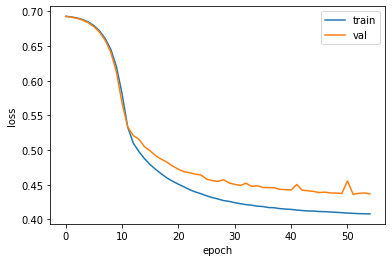

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

드롭아웃을 사용하지 않았기 때문에 이전보다 훈련 손실과 검증 손실 사이에 차이가 있지만 훈련 과정이 잘 수렴되고 있는 것을 확인할 수 있다.

이제 가장 좋았던 2개의 순환층을 쌓은 모델을 다시 로드하여 테스트 세트에 대한 성능을 확인해보자.

In [20]:
test_seq = pad_sequences(test_input, maxlen=100)
rnn_model = keras.models.load_model('best-2rnn-model.h5')
rnn_model.evaluate(test_seq, test_target)

782/782 [==============================] - 5s 5ms/step - loss: 0.4316 - accuracy: 0.7974


[0.43162739276885986, 0.7974399924278259]

이 모델을 드롭아웃을 적용하여 과대적합을 잘 억제했기 때문에 테스트 세트의 성능이 검증 세트와 크게 차이나지 않는다.